# Simple viewer for Grads files

Need to read this very carefully:
https://ipywidgets.readthedocs.io/en/latest/user_install.html

nodejs didn't install properly on my Windows 7 machine, so I installed it from internet.

Now works on Jupyter Notebook, but not on Jupyter Lab.

In [1]:
%matplotlib inline

import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from read_grads import read_metadata, read_data
from widget_selection import result_and_time_options, altitude_options

## Select the grads control file by clicking on the 'Upload' button

In [2]:
uploader = widgets.FileUpload(accept=".ctl", multiple=False)
display(uploader)

FileUpload(value={}, accept='.ctl', description='Upload')

In [3]:
filename = "attm101.ctl"
uploaded_file = uploader.value
if len(uploaded_file) != 1: print('!!! UNEXPECTED NUMBER OF CONTROL FILES !!!', len(uploaded_file))
for key in uploaded_file:
    filename = key
print('Selected control file is',filename)

!!! UNEXPECTED NUMBER OF CONTROL FILES !!! 0
Selected control file is attm101.ctl


## Extract the metadata, find the results file and extract the data

In [4]:
metadata, varsKeys = read_metadata(filename)

grads_filename = filename[:-4]+"_"+metadata["TDEF"][0][-4:]+".grd"
print('Name of grads file is:',grads_filename)

data = read_data(metadata, varsKeys, grads_filename)

Name of grads file is: attm101_2000.grd


## Select data to plot

### Choose result type and time step

In [5]:
time_widget, result_widget = result_and_time_options(metadata, varsKeys)

display(time_widget)
display(result_widget)

Dropdown(description='Date stamp:', options=(('1jan2000', 0), ('1jan2000+1mo', 1), ('1jan2000+1mo+1mo', 2)), v…

Dropdown(description='Result type:', options=(('GH', 0), ('TEMP', 1), ('U', 2), ('V', 3), ('Q', 4), ('RH', 5),…

### Choose altitude if necessary

In [8]:
time_step = time_widget.value

result_index = result_widget.value
result_type = varsKeys[result_index][0]
result_zeds = varsKeys[result_index][1]

if result_zeds != 0:
    altitude_widget = altitude_options(metadata)
    display(altitude_widget)

## Plot data

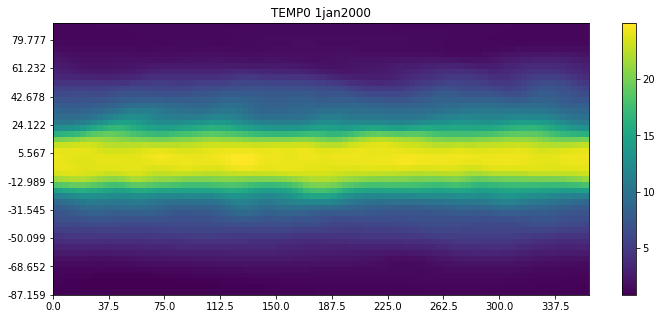

In [9]:
if result_zeds != 0:
    altitude_step = altitude_widget.value
    altitude_string = " altitude "+str(metadata["ZDEF"][altitude_step])
    zed_multiplier = result_zeds
else:
    altitude_step = 0
    altitude_string = ""
    zed_multiplier = 1

heat = data[result_type][time_step*(zed_multiplier)+altitude_step].reshape(len(metadata["YDEF"]), len(metadata["XDEF"]))
lenX = len(metadata["XDEF"])
lenY = len(metadata["YDEF"])

df = pd.DataFrame(heat, index= metadata["YDEF"], columns=metadata["XDEF"])

plt.figure(0,(12.,5.))
heatmap = plt.pcolor(df)
plt.title(result_type+" "+metadata["TDEF"][time_step]+altitude_string)
plt.yticks(np.arange(0, lenY, 5), df.index[0::5])
plt.xticks(np.arange(0, lenX, 10), df.columns[0::10])
plt.colorbar(heatmap)
plt.show()